In [1]:
from vpython import * 
from pypylon import pylon
import cv2 as cv
import csv
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import style
from matplotlib.ticker import FormatStrFormatter
import time
from openpyxl import Workbook
import xlwt
from datetime import datetime
import random
from itertools import count
from IPython.display import display, clear_output
from matplotlib.animation import FuncAnimation
from drawnow import drawnow
from bokeh.plotting import curdoc, figure
import plotly.express as px
import plotly.graph_objs as go
import pandas as pd
import numpy as np
import numpy.ma as ma
import math
import time
import circle_fit as cf
import matplotlib.colors as mcolors
import config_constants as cc
%matplotlib inline 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,original_pos_xy,Final_pos_xy,max_xy,min_xy,Radius_x,Radius_y,Area
0,"(15.0140625, 11.526562499999999)","([15.0046875], [11.526562499999999])","(15.032812499999999, 11.5453125)","(14.995312499999999, 11.5078125)",0.01875,0.01875,0.11775


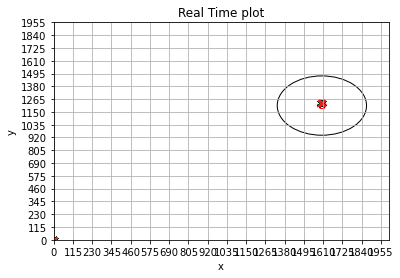

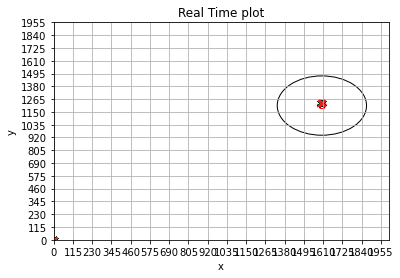

In [2]:
conversion = cc.conversion

# conecting to the first available camera
camera = pylon.InstantCamera(pylon.TlFactory.GetInstance().CreateFirstDevice())
camera.Open()
#camera.Width = 4112
#camera.Height = 2172
camera.CenterX.SetValue(True)
camera.Width.SetValue(2956)
camera.CenterY.SetValue(True)
camera.Height.SetValue(1988)
camera.Close()
# Grabing Continusely (video) with minimal delay
camera.StartGrabbing(pylon.GrabStrategy_LatestImageOnly)
converter = pylon.ImageFormatConverter()

# converting to opencv bgr format
converter.OutputPixelFormat = pylon.PixelType_BGR8packed
converter.OutputBitAlignment = pylon.OutputBitAlignment_MsbAligned

# def for circle shape detection
prevCircle = None
dist = lambda x1,y1,x2,y2: (x1-x2)**2+(y1-y2)**2
x = np.empty(1)
y = np.empty(1)
#livegraph
fig = plt.figure()
ax = fig.add_subplot(111)
circle_x = cc.circle['circle_x'] 
circle_y = cc.circle['circle_y']    
circle_r = cc.circle['circle_r']
circle1 = plt.Circle( (circle_x  /conversion, circle_y/conversion ), circle_r/conversion , fill = False )
circle2 = plt.Circle( (circle_x  /conversion, circle_y/conversion ), 0.25/conversion , fill = False, color = 'r', linestyle = '--' )
ax.add_artist( circle1 )
ax.add_artist( circle2 )
#fig, (ax1, ax2) = plt.subplots(2)
ax.set_xlim(500,2000)
ax.set_ylim(0,1000)
ax.set_xticks(np.arange(0, 2000, 115))
ax.set_yticks(np.arange(0, 2000, 115))
plt.grid()
#def for background change to black and white
object_detector = cv.createBackgroundSubtractorMOG2(history=100, varThreshold=70)

#def for set time counter 
t = 0
tmax = 1000
dt = 1
#display 
scene1 = canvas()
#display(fig)
#measure the time
st = time.time()
#Camera grabbing while loop and set count time 
while camera.IsGrabbing() and t < tmax:
    grabResult = camera.RetrieveResult(5000, pylon.TimeoutHandling_ThrowException)
    if grabResult.GrabSucceeded():
        # Access the image data
        image = converter.Convert(grabResult)
        img = image.GetArray()
    if not grabResult.GrabSucceeded: break
    
#Frame color control 
    GrayFrame = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    blurFrame = cv.GaussianBlur(GrayFrame, (17,17),0)
    thresh = cv.threshold(blurFrame, 35, 255, cv.THRESH_BINARY)[1]
    
    #imc = cv.medianBlur(imc, 5)
    
    #cv.rectangle(imc, (100, 100), (300, 300), (255, 0, 0), 2)
    #roi = imc[100:300, 100:300]
    #roi_gray = cv.cvtColor(roi, cv.COLOR_BGR2GRAY)
    #mask = np.zeros(thresh.shape, dtype='unit8')
    #cv.circle(mask, (150, 150), 100, 255, -1)

    #roi = blurFrame[340: 600, 500: 700]
    #mask = object_detector.apply(blurFrame)
    #mask1 = cv.threshold(roi, 254, 255, cv.THRESH_BINARY)
    
    #detect things without dark room used to use imc
    circles = cv.HoughCircles(thresh, cv.HOUGH_GRADIENT, 1, 5000, param1=250, param2=13, minRadius=10, maxRadius=30)
    if circles is not None:
        for i in circles[0, :]:
            x = np.append(x , i[0])
            y = np.append(y , i[1])
            center = np.uint16(np.around((i[0], i[1])))
            # circle center
            cv.circle(img, center, 1, (0, 100, 100), 3)
            # circle outline
            radius = np.uint16(np.around(i[2]))
            cv.circle(img, center, radius, (0, 255, 0), 3)
            
            #graph section
            sct = ax.scatter(x*conversion, y*conversion, marker='x') 
            sct.set_offsets(np.c_[x,y])
            plt.title("Real Time plot")
            plt.xlabel("x")
            plt.ylabel("y")
            
            clear_output(wait=True)
            

            #data
            xs = x[1:]
            ys = y[1:]
            max_value_x = np.max(xs)
            max_value_y = np.max(ys)
          

            min_value_x = np.min(xs)
            min_value_y = np.min(ys)
            
            R_x = (max_value_x-min_value_x)/2
            R_y = (max_value_y-min_value_y)/2
            Area_E = R_x*R_y*3.14
            
            scene2 = canvas()
            data = {
                'original_pos_xy':[(x[1]*conversion, y[1]*conversion)],
                'Final_pos_xy': [(x[-1:]*conversion, y[-1:]*conversion)],
                'max_xy': [(max_value_x*conversion,max_value_y*conversion)],
                'min_xy': [(min_value_x*conversion,min_value_y*conversion)],
                'Radius_x':[R_x*conversion],
                'Radius_y':[R_y*conversion],
                'Area':[(Area_E*conversion)],
                #'center point':[()]
                #'point's none zero: [(np.count_nonzero(x[0])*0.2645833333, np.count_nonzero(y[0])*0.2645833333)],
            }
    
# create dataframe from data
            df1 = pd.DataFrame(data)
            #df1.to_csv('existing.csv', mode='a', index=False, header=False) 
# display the dataframe
            display(df1,fig)
#out put section for output the coordinate and video
    imS = cv.resize(img, (1478, 994))
    cv.imshow("live video", imS)
    #cv.imshow('video testing', img)
    #cv.imshow('video',  roi_mask)
    cv.imshow("detection", thresh)
#picture detacting watiing section
    key = cv.waitKey(30) 
    if key == 27 : break
    #count time 
    t = t + dt

    file_dat = {
                'Time (s)': t,
                'X (mm)': x[-1]*conversion,
                'Y (mm)': y[-1:]*conversion,
            }
    df2 = pd.DataFrame(file_dat)
    df2.to_csv('test.csv', mode='a', index=False, header=False)
#print value in a different box    
  
#camera control         
camera.StopGrabbing()
cv.destroyAllWindows()

In [3]:
#print(xcoords)
#print(ycoords)

In [4]:
#plt.scatter(xcoords,ycoords)

In [5]:
data = [[xcoords[i], ycoords[i]] for i in range(len(xcoords))]
xc, yc, r, sigma = cf.least_squares_circle((data))
print('Center coordinates:',xc,yc,'mm')
print('Radius:',r,'mm')
print('Residual error:',sigma,'mm')

cf.plot_data_circle(xcoords,ycoords,xc,yc,r)

NameError: name 'xcoords' is not defined

In [6]:
et = time.time()
elapsed_time = et - st
print ('CPU execution time code', time.process_time(), 'seconds')
print('Execution time:', elapsed_time, 'seconds')

CPU execution time code 1203.4375 seconds
Execution time: 682.7483556270599 seconds


In [7]:
print('distance from center (mm)',3.5265785508011978-x[-1:]*conversion, 4.396458482120711-y[-1:]*conversion)
center = (np.sqrt((3.5265785508011978-x[-1:]*conversion)**2 + (4.396458482120711-y[-1:]*conversion)**2))
print(center)

distance from center (mm) [-11.47810895] [-7.13010402]
[13.51241534]


,original_pos_xy,Final_pos_xy,max_xy,min_xy,Radius_x,Radius_y,Area
0,"(15.0140625, 11.526562499999999)","([15.0046875], [11.526562499999999])","(15.032812499999999, 11.5453125)","(14.995312499999999, 11.5078125)",0.01875,0.01875,0.11775


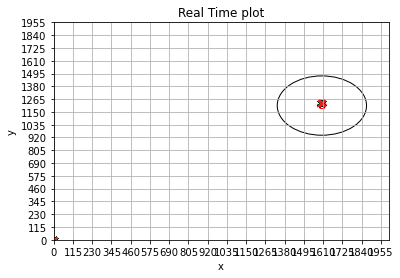

In [8]:
data = {
                'original_pos_xy':[(x[1]*conversion, y[1]*conversion)],
                'Final_pos_xy': [(x[-1:]*conversion, y[-1:]*conversion)],
                'max_xy': [(max_value_x*conversion,max_value_y*conversion)],
                'min_xy': [(min_value_x*conversion,min_value_y*conversion)],
                'Radius_x':[R_x*conversion],
                'Radius_y':[R_y*conversion],
                'Area':[(Area_E*conversion)]
       }
display(df1,fig)


In [9]:
x1 = x*conversion
xd = np.delete(x1, 0)
print('x', xd)
y2 = y*conversion
yd = np.delete(y2, 0)
print('y',yd)
ti = 1
displacement = (x1,y2)

x [15.0140625 15.0140625 15.0140625 15.0140625 15.0140625 15.0140625
 15.0046875 15.0140625 15.0140625 15.0140625 15.0140625 15.0140625
 15.0140625 15.0140625 15.0046875 15.0046875 15.0046875 15.0140625
 15.0140625 15.0046875 15.0140625 15.0046875 15.0140625 15.0140625
 15.0046875 15.0234375 15.0046875 15.0234375 15.0046875 15.0234375
 15.0046875 15.0046875 15.0234375 15.0046875 15.0046875 15.0046875
 15.0046875 15.0046875 15.0234375 15.0046875 15.0046875 15.0140625
 15.0140625 15.0234375 15.0046875 15.0046875 15.0046875 15.0046875
 15.0046875 15.0234375 15.0046875 15.0234375 15.0046875 15.0234375
 15.0046875 15.0046875 15.0234375 15.0234375 15.0234375 15.0046875
 15.0234375 15.0046875 15.0234375 15.0234375 15.0234375 15.0234375
 15.0234375 15.0234375 15.0234375 15.0046875 15.0234375 15.0234375
 15.0234375 15.0046875 15.0046875 15.0140625 15.0046875 15.0046875
 15.0234375 15.0046875 15.0046875 15.0046875 15.0046875 15.0046875
 15.0046875 15.0046875 15.0046875 15.0046875 15.0046875 15.0

In [10]:
dis = 0 
sp = np.array([1,2,3,4])
xa = np.array([xd[0], xd[1], xd[-2], xd[-1]])
ya = np.array([yd[0], yd[1], yd[-2], yd[-1]])
for i in range(len(xa)-2):
    dis += sqrt((xa[i+1] - xa[i])**2 + (ya[i+1]-ya[i])**2)
    
print('dis', dis)
print('d/t', dis/ti)

dis 0.0
d/t 0.0


In [11]:
dist = np.sqrt((yd[-1]-yd[0])**2 + (xd[-1]-xd[0])**2)
print(dist)

#angle to xaxis
thetax = 180*np.arcsin(abs(yd[-1]-yd[0])/dist)/np.pi
print('angle to x:',thetax)

#angle to yaxis
thetay = 180*np.arcsin(abs(xd[-1]-xd[0])/dist)/np.pi
print('angle to y',thetay)

0.009375000000000355
angle to x: 0.0
angle to y 90.0


Center coordinates: 15.018406137529649 11.52499806962508 mm
Radius: 0.012318500096202183 mm
Residual error: 0.012503017908666075 mm


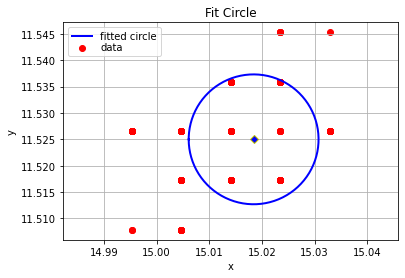

In [12]:
data = [[xd[i], yd[i]] for i in range(len(xd))]
xc, yc, r, sigma = cf.least_squares_circle((data))
print('Center coordinates:',xc,yc,'mm')
print('Radius:',r,'mm')
print('Residual error:',sigma,'mm')

cf.plot_data_circle(xd,yd,xc,yc,r)

In [13]:
x_steps = np.count_nonzero(xd)
y_steps = np.count_nonzero(yd)
print(x_steps, y_steps)

994 994


In [14]:
steps = list(range(1,x_steps+1))
print(steps)   

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 22

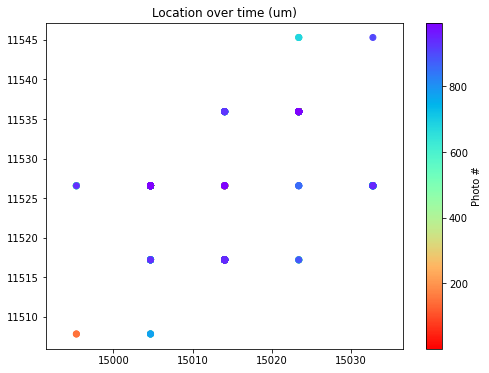

In [17]:
figure = plt.figure(figsize=(8, 6))
plt.scatter(xd*1000,yd*1000,c=steps,cmap='rainbow_r')
plt.colorbar(label='Photo #')
plt.title("Location over time (um)")
plt.axis('equal')
plt.show()

In [16]:
#### P_E = 2*3.14*((R_x**2+R_y**2)/2)**(1/2)
print('perimeter Ellipse', P_E)
print('distance/time(V)',P_E/ti)

NameError: name 'P_E' is not defined

In [ ]:
ax = plt.axes(projection="3d")
ax.plot(xd,yd,ti)
plt.show()

In [ ]:
plt.plot(xd,yd,ti)
plt.xlabel('time')
plt.ylabel('displacement')
plt.title("5sec ch2 100")
plt.show()

In [ ]:
#graph for circle x
plt.scatter(steps,xd)
plt.xlabel('step')
plt.ylabel('x')
plt.title("stepsx")
plt.show()

In [ ]:
#graph for circle y
plt.scatter(steps,yd)
plt.xlabel('step')
plt.ylabel('y')
plt.title("stepsy")
plt.show()

In [ ]:
#graph for circle x, y
plt.scatter(xd,yd)
plt.xlabel('x')
plt.ylabel('y')
plt.title("step-xy")
plt.show()

In [ ]:
dx = len(xd)
print('ds',dx)
dy = len(yd)
print('dy',dy)
dt = (dy**2+dx**2)**(1/2)
print ('dt', dt)
print('d/t', dt/ti)

In [ ]:
x_steps = np.count_nonzero(xa)
y_steps = np.count_nonzero(ya)
print(x_steps, y_steps)

In [ ]:
#graph for steps
plt.scatter(sp,xa)
plt.xlabel('steps')
plt.ylabel('x')
plt.title("stepsx-only move step")
plt.show()

In [ ]:
plt.scatter(sp,ya)
plt.xlabel('steps')
plt.ylabel('y')
plt.title("stepsy-only move step")
plt.show()

In [ ]:
plt.scatter(sp,ya)
plt.xlabel('stepy')
plt.ylabel('y')
plt.title("steps")
plt.show()

In [ ]:
plt.scatter(sp,xa,ya)
plt.xlabel('step-tot')
plt.ylabel('displacement')
plt.title("steps")
plt.show()